# CrateRover motor sizing

One of the most important parts of the rover is the drive system. The required power and torgue necessary to move
the rover largely determines the size of the motors and batteries. Additionally the sizing of the drive system
will determine a large part of the weight of the rover.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from robot_functions import *
from crate_rover_specs import *

rover_specs = RoverSpecification()
rover = Rover(rover_specs)

## Drive motors

The following calculations are based on the following [PhD thesis](https://www.chalmers.se/SiteCollectionDocuments/Energi%20och%20milj%C3%B6/Elteknik/EmmaGrunditz_PhDthesis_lowrez.pdf).

    Design and Assessment of Battery Electric Vehicle Powertrain, with Respect to Performance, Energy Consumption and Electric Motor Thermal Capability
    Emma Arfa Grunditz
    Department of Energy and Environment
    Division of Electric Power Engineering
    Chalmers University of Technology
    Gotenborg, Sweden 2016

The first part of the drive system calculation is to determine the following two parameters:

* The minimum torgue required to allow the rover to drive up the minimum required slope.
* The minimum power required to allow the rover to achieved the required transport velocity.

The following graphs provide insight in the wheel force and wheel power for different velocities and slope angles.

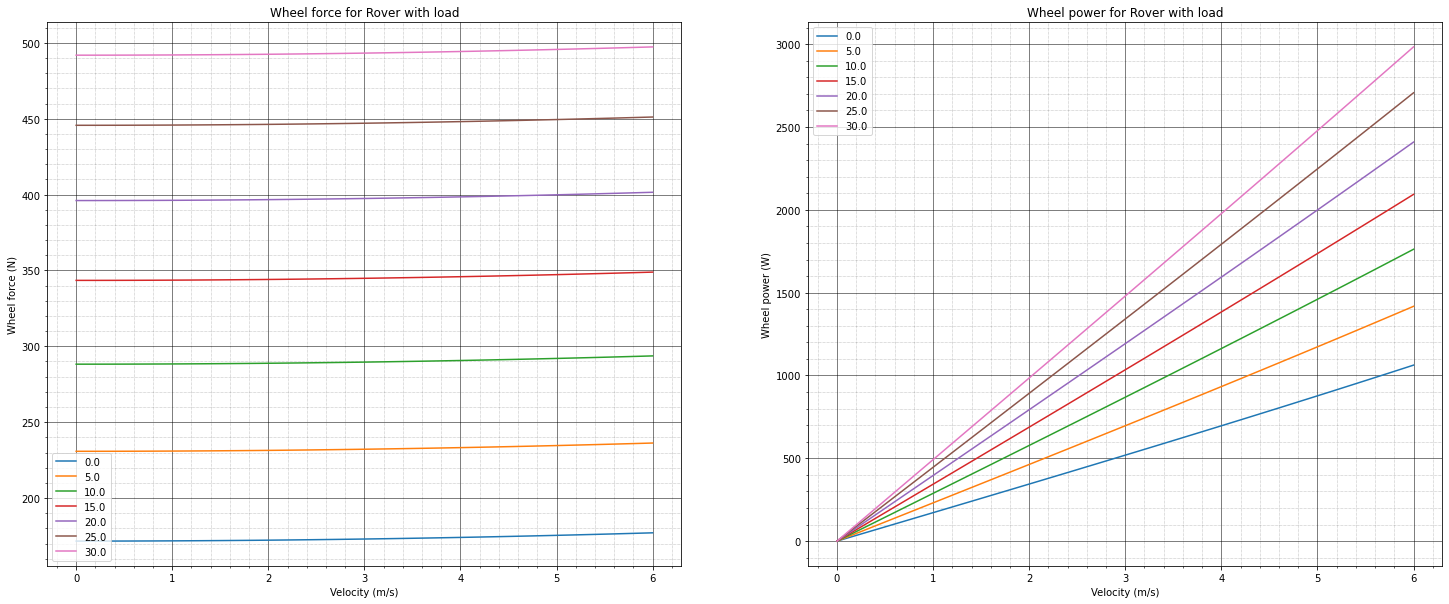

In [2]:
# Calculate wheel forces and wheel power
wheel_forces_with_load = []
wheel_power_with_load = []
columns = ['velocity']

velocity_step = 0.1
maximum_velocity = rover_specs.performance.maximum_velocity_on_flat_ground() * 3 + velocity_step
for velocity in np.arange(0.0, maximum_velocity,
                          velocity_step):

    forces_with_load = [ velocity ]
    powers_with_load = [ velocity ]

    slope_step = 5.0
    for slope in np.arange(0.0, rover_specs.performance.maximum_slope_angle_without_load() + slope_step,
                           slope_step):

        slope_as_text = str(slope)
        if slope_as_text not in columns:
            columns.append(slope_as_text)

        wheel_force_with_load, power_with_load = rover.wheel_force_and_power_with_cargo(
            velocity,
            slope)

        forces_with_load.append(wheel_force_with_load)
        powers_with_load.append(power_with_load)

    wheel_forces_with_load.append(forces_with_load)
    wheel_power_with_load.append(powers_with_load)

force_with_load_df = pd.DataFrame(wheel_forces_with_load, columns=columns)
power_with_load_df = pd.DataFrame(wheel_power_with_load, columns=columns)

fig, ax_group = plt.subplots(1, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_with_load_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover with load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

power_with_load_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Wheel power for Rover with load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Wheel power (W)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

plt.show()

Once the force and power curves for different velocities and slope angles have been created the next step is to 
determine the velocity-force and velocity-acceleration diagrams. From these diagrams it is possible to determine the
characteristics of the rover engines.

In [3]:
# Determine minimum power and force requirements
minimum_power_required = power_with_load_df[str(rover_specs.performance.maximum_slope_angle_with_maximum_load())][rover_specs.performance.maximum_velocity_on_sloped_ground() * (1 / velocity_step)]

force_at_max_slope = minimum_power_required / rover_specs.performance.maximum_velocity_on_sloped_ground()
torque_at_max_slope = force_at_max_slope * rover_specs.chassis.wheel.radius_in_meters

velocity_max_on_flat_ground = rover.velocity_for_slope_and_power(
    minimum_power_required, 
    rover.frontal_surface(),
    rover.weight_with_cargo_in_kg(),
    0.0)

force_at_zero_slope = minimum_power_required / velocity_max_on_flat_ground
torque_at_zero_slope = force_at_zero_slope * rover_specs.chassis.wheel.radius_in_meters

# Calculate motor torque, motor speed and motor power
torque_at_zero_slope_per_motor = torque_at_zero_slope / rover_specs.chassis.number_of_wheels
maximum_rotation_speed = velocity_max_on_flat_ground / (2.0 * math.pi * rover_specs.chassis.wheel.radius_in_meters)
power_at_zero_slope_per_motor = torque_at_zero_slope_per_motor * maximum_rotation_speed * 2.0 * math.pi

torque_at_max_slope_per_motor = torque_at_max_slope / rover_specs.chassis.number_of_wheels
maximum_slope_rotation_speed = rover_specs.performance.maximum_velocity_on_sloped_ground() / (2.0 * math.pi * rover_specs.chassis.wheel.radius_in_meters)
power_at_max_slope_per_motor = torque_at_max_slope_per_motor * maximum_slope_rotation_speed * 2.0 * math.pi

motor_requirements = pd.DataFrame(
    [
        [ 0.0, maximum_rotation_speed * 60.0, torque_at_zero_slope_per_motor, power_at_zero_slope_per_motor ],
        [ rover_specs.performance.maximum_slope_angle_with_maximum_load(), maximum_slope_rotation_speed * 60.0, torque_at_max_slope_per_motor, power_at_max_slope_per_motor ]
    ], 
    columns=['slope (degrees)', 'rotation speed (RPM)', 'torque - ideal (Nm)', 'power - ideal (W)'])

motor_requirements

,slope (degrees),rotation speed (RPM),torque - ideal (Nm),power - ideal (W)
0,0.0,302.131077,5.437019,172.022337
1,15.0,152.788745,10.751396,172.022337


In [4]:
# Use gearing efficiencies to figure out how much power the motor needs to have

# Guessing to have 4 gears
# 1) Motor 90 degrees to vertical drive shaft
# 2) vertical drive shaft to horizontal at top of swerve module
# 3) horizontal drive shaft to vertical drive shaft at side of swerve module
# 4) Drive shaft to wheel
#
# Assume 95% efficiency for each gear

drive_efficiency = math.pow(0.95, 4)
motor_requirements['torque - friction (Nm)'] = motor_requirements['torque - ideal (Nm)'] / drive_efficiency
motor_requirements['power - friction (W)'] = motor_requirements['power - ideal (W)'] / drive_efficiency

motor_requirements['torque - safety-factor (Nm)'] = motor_requirements['torque - friction (Nm)'] * Engineering.safety_factor_propulsion
motor_requirements['power - safety-factor (W)'] = motor_requirements['power - friction (W)']  * Engineering.safety_factor_propulsion

motor_requirements

,slope (degrees),rotation speed (RPM),torque - ideal (Nm),power - ideal (W),torque - friction (Nm),power - friction (W),torque - safety-factor (Nm),power - safety-factor (W)
0,0.0,302.131077,5.437019,172.022337,6.675233,211.198302,8.344041,263.997878
1,15.0,152.788745,10.751396,172.022337,13.199894,211.198302,16.499867,263.997878


In [5]:
gear_ratio = 16.0

motor_geared_requirements = pd.DataFrame(
    [
        [ 0.0, maximum_rotation_speed * 60.0 * gear_ratio, motor_requirements['torque - safety-factor (Nm)'][0] / gear_ratio, motor_requirements['power - safety-factor (W)'][0] ],
        [ rover_specs.performance.maximum_slope_angle_with_maximum_load(), maximum_slope_rotation_speed * 60.0 * gear_ratio, motor_requirements['torque - safety-factor (Nm)'][1] / gear_ratio, motor_requirements['power - safety-factor (W)'][1] ]
    ], 
    columns=['slope (degrees)', 'rotation speed (RPM)', 'torque - geared (Nm)', 'power - geared (W)'])

motor_geared_requirements


,slope (degrees),rotation speed (RPM),torque - geared (Nm),power - geared (W)
0,0.0,4834.097239,0.521503,263.997878
1,15.0,2444.619926,1.031242,263.997878


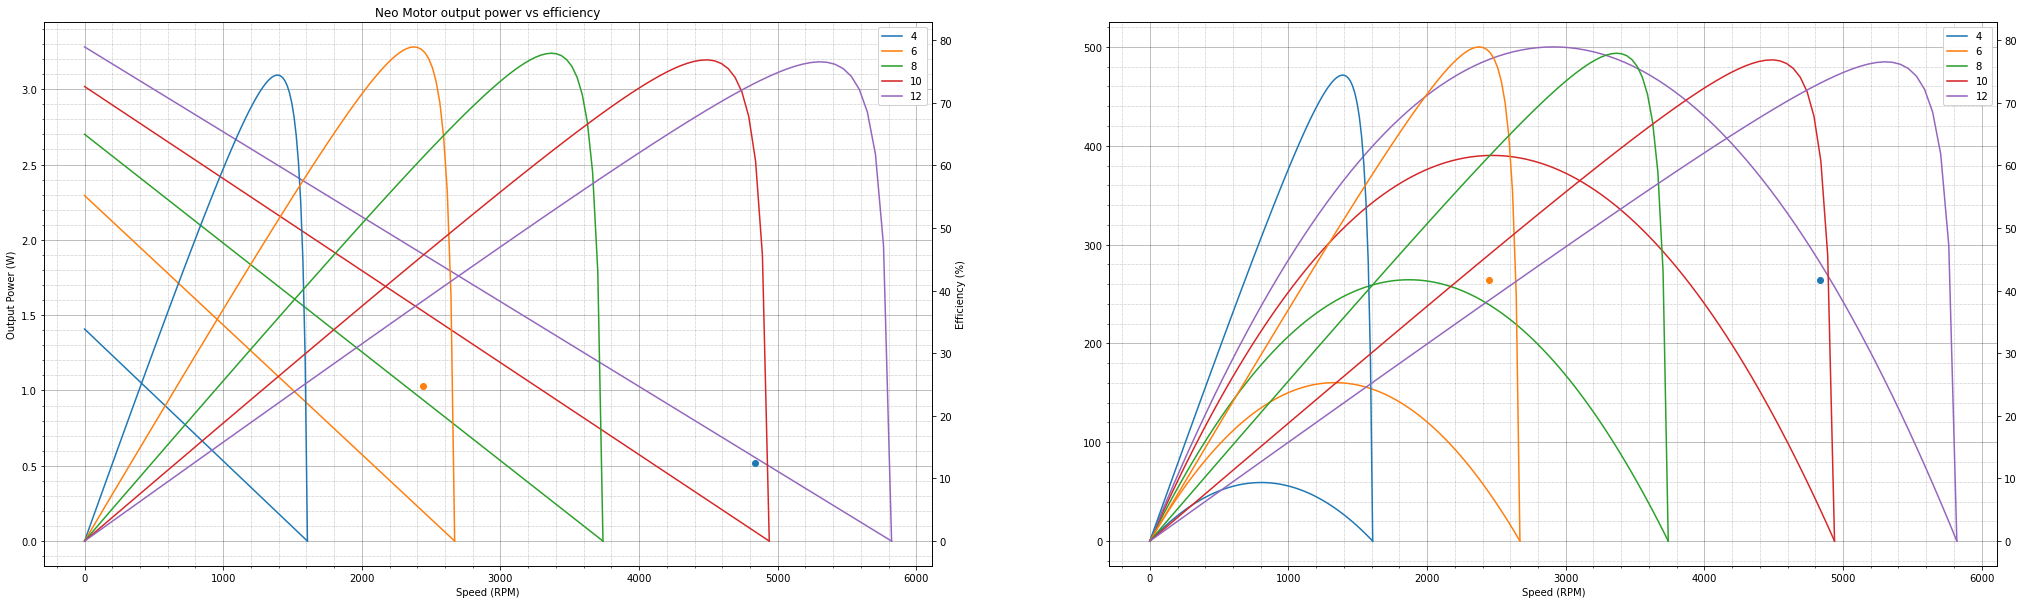

In [6]:
dataframes = []
for motor_name in ['neo']:
    for voltage in [4, 6, 8, 10, 12]:
        file_name = f'data/motor-curves/{motor_name}/MotorCurve-{voltage}V.csv'
        dataframe = pd.read_csv(file_name)
        dataframe['voltage'] = voltage
        dataframe['name'] = motor_name
        dataframes.append(dataframe)

neo_motor_curves = pd.concat(dataframes)
neo_motor_curves.set_index('Speed (RPM)', inplace=True)

fig, ax_group = plt.subplots(1, 2, figsize=(35, 10), sharex=False)

# unpack all the axes subplots
figures = ax_group.ravel()

fig1_eff = figures[0].twinx()
fig2_eff = figures[1].twinx()

figures[0].set_title('Neo Motor torgue vs efficiency')

figures[0].set_xlabel('Speed (RPM)')
figures[0].set_ylabel('Torque (Nm)')
fig1_eff.set_ylabel('Efficiency (%)')

#neo_motor_curves.set_index('Speed (RPM)', inplace=True)
neo_motor_curves.groupby('voltage')['Torque (Nm)'].plot(ax=figures[0], legend=True)
figures[0].set_axisbelow(True)
figures[0].minorticks_on()
figures[0].grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
figures[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)
neo_motor_curves.groupby('voltage')['Efficiency (%)'].plot(ax=fig1_eff, legend=True)

figures[0].scatter(motor_geared_requirements['rotation speed (RPM)'][0], motor_geared_requirements['torque - geared (Nm)'][0], label='flat')
figures[0].scatter(motor_geared_requirements['rotation speed (RPM)'][1], motor_geared_requirements['torque - geared (Nm)'][1], label='slope')

figures[0].set_title('Neo Motor output power vs efficiency')

figures[0].set_xlabel('Speed (RPM)')
figures[0].set_ylabel('Output Power (W)')
fig1_eff.set_ylabel('Efficiency (%)')

neo_motor_curves.groupby('voltage')['Output Power (W)'].plot(ax=figures[1], legend=True)
figures[1].set_axisbelow(True)
figures[1].minorticks_on()
figures[1].grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
figures[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)
neo_motor_curves.groupby('voltage')['Efficiency (%)'].plot(ax=fig2_eff, legend=True)

figures[1].scatter(motor_geared_requirements['rotation speed (RPM)'][0], motor_geared_requirements['power - geared (W)'][0], label='flat')
figures[1].scatter(motor_geared_requirements['rotation speed (RPM)'][1], motor_geared_requirements['power - geared (W)'][1], label='slope')


## Steering motor

In [7]:
wheel_width = 0.075
distance_between_axle_and_wheel = 0.075
friction = FrictionForRubber()

force_on_wheel = rover.weight_with_cargo_in_kg() * Physics.gravitational_acceleration() / rover_specs.chassis.number_of_wheels
friction_on_wheel = force_on_wheel * friction.static('concrete', 'dry')

steering_torque = friction_on_wheel * (0.5 * wheel_width + distance_between_axle_and_wheel)

steering_torque

# This is not correct. 
# 1 ) The friction calculation is too simple
# see: https://hypertextbook.com/facts/2006/MatthewMichaels.shtml -> It depends on the twisting of the rubber etc. and is
# non-linear. We're after a worst case scenario for large turning angles
#
# 2) The current design is such the that wheel is able to roll a bit while it is being turned. The inner and outer
# parts of the wheel are forced to turn at the same speed so there will be some friction somewhere (most likely the
# inner is moving faster than it should and the outer is moving slower than it should)

19.306842187499996

#### Battery sizing

* Separate motor power from compute power